In [54]:
import pandas as pd
import numpy as np
from PIL import Image
from typing import Optional
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
import open_clip

In [55]:
class MisogynyDataset(Dataset):
    def __init__(self, data, label_map, transform=None):
        self.data = data.reset_index(drop=True)
        self.label_map = label_map

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transform,
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        image = self.transform(image)
        label = self.label_map[row["image_label"]]
        caption = row["image_caption"]
        return image, caption, label

In [56]:
class MisogynyDataLoader:
    def __init__(self, csv_file="data_csv.csv", batch_size=16, test_size=0.2, random_state=42,
                 train_transform=None, test_transform=None, num_workers=0, pin_memory=False):
        data = pd.read_csv(csv_file)
        label_map = {"kitchen":0, "shopping":1, "working":2, "leadership":3}

        train_df, test_df = train_test_split(
            data,
            test_size=test_size,
            random_state=random_state,
            shuffle=True,
            stratify=data["image_label"]
        )

        self.train_dataset = MisogynyDataset(train_df, label_map, transform=train_transform)
        self.test_dataset = MisogynyDataset(test_df, label_map, transform=test_transform)

        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True,
                                       num_workers=num_workers, pin_memory=pin_memory)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=num_workers, pin_memory=pin_memory)

In [57]:
class BERTEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.model_bert = BertModel.from_pretrained("bert-base-uncased")
        self.model_bert.eval()

    def forward(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model_bert(**inputs)
        token_embeddings = outputs.last_hidden_state
        attention_mask = inputs["attention_mask"]
        mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sentence_embeddings = (token_embeddings * mask).sum(dim=1) / mask.sum(dim=1)
        embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return embeddings

In [58]:
class OpenClipVitEmbedder(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(
            model_name="ViT-B-32", pretrained="openai"
        )
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

    def forward(self, image_tensor):
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            image_features = self.model.encode_image(image_tensor)
        image_features = F.normalize(image_features, p=2, dim=-1)
        return image_features

In [59]:
class PCALayer(nn.Module):
    def __init__(self, mean, components):
        super().__init__()
        mean = torch.tensor(mean, dtype=torch.float32)
        components = torch.tensor(components, dtype=torch.float32)
        self.register_buffer("mean", mean)
        self.register_buffer("weight", components)

    def forward(self, x):
        # x: (B, D)
        x = x - self.mean
        return torch.matmul(x, self.weight.T)  # (B, K)

In [60]:
def collect_embeddings(dataloader, text_model, image_model, device):
    text_embeddings = []
    image_embeddings = []

    for images, captions, _ in dataloader:
        captions = list(captions)
        with torch.no_grad():
            text_emb = text_model(captions).to("cpu")
            image_emb = image_model(images).to("cpu")
        text_embeddings.append(text_emb.numpy())
        image_embeddings.append(image_emb.numpy())

    text_embeddings = np.vstack(text_embeddings)
    image_embeddings = np.vstack(image_embeddings)
    return text_embeddings, image_embeddings

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloaders = MisogynyDataLoader()
train_loader = dataloaders.train_loader

text_model = BERTEmbedder().to(device)
image_model = OpenClipVitEmbedder(device=device)

text_train_emb, image_train_emb = collect_embeddings(train_loader, text_model, image_model, device)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2068.46it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/Users/vishnurchityala/FILES/USERS/VISHNU/PROJECTS/ONGOING-PROJECTS/graph-networks/venv/lib/python3.12/site-packages/open_clip/factory

In [62]:
reduced_dimension = 100
pca_text = PCA(n_components=reduced_dimension, svd_solver="full")
pca_text.fit(text_train_emb)
pca_image = PCA(n_components=reduced_dimension, svd_solver="full")
pca_image.fit(image_train_emb)

np.save(f"bert_pca_mean_{reduced_dimension}.npy", pca_text.mean_)
np.save(f"bert_pca_components_{reduced_dimension}.npy", pca_text.components_)
np.save(f"clip_pca_mean_{reduced_dimension}.npy", pca_image.mean_)
np.save(f"clip_pca_components_{reduced_dimension}.npy", pca_image.components_)

In [63]:
bert_pca_layer = PCALayer(pca_text.mean_, pca_text.components_)
clip_pca_layer = PCALayer(pca_image.mean_, pca_image.components_)

In [64]:
for images, captions, _ in train_loader:
    text_emb = text_model(captions)
    text_emb_pca = bert_pca_layer(text_emb)

    image_emb = image_model(images)
    image_emb_pca = clip_pca_layer(image_emb)

    print("Text PCA shape:", text_emb_pca.shape)
    print("Image PCA shape:", image_emb_pca.shape)
    break

Text PCA shape: torch.Size([16, 100])
Image PCA shape: torch.Size([16, 100])


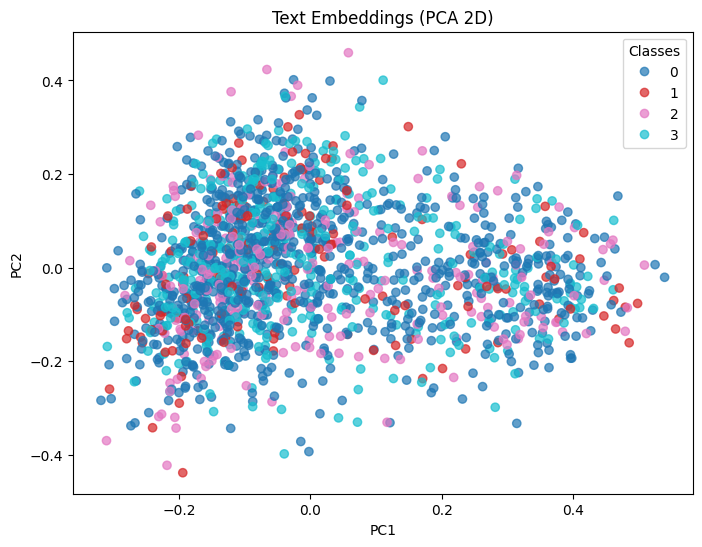

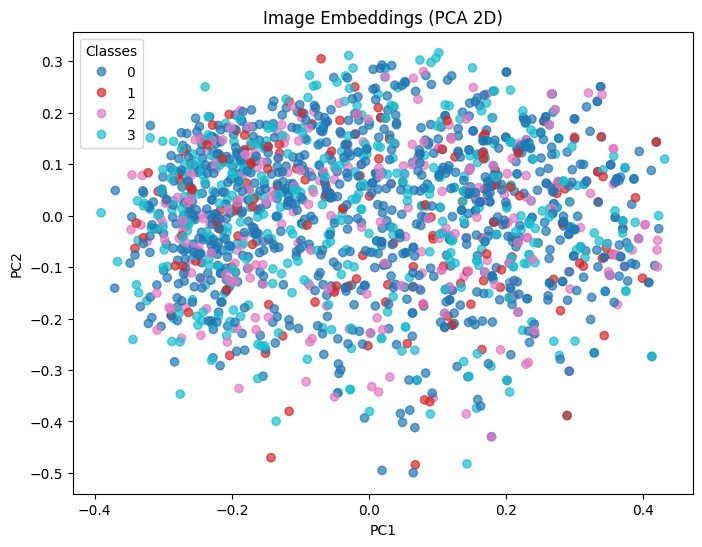

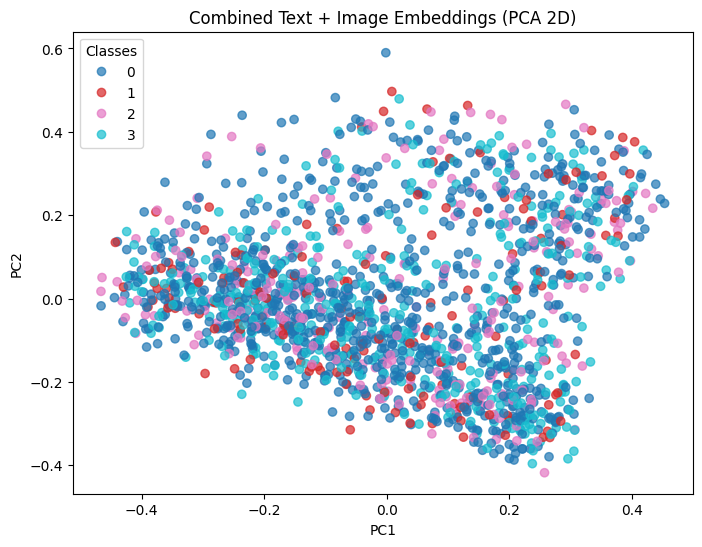

In [65]:
import matplotlib.pyplot as plt

labels = [label for _, _, label in dataloaders.train_dataset] 

pca_text_2d = PCA(n_components=2)
text_emb_2d = pca_text_2d.fit_transform(text_train_emb)

pca_image_2d = PCA(n_components=2)
image_emb_2d = pca_image_2d.fit_transform(image_train_emb)

combined_emb = np.concatenate([text_train_emb, image_train_emb], axis=1)
pca_combined_2d = PCA(n_components=2)
combined_emb_2d = pca_combined_2d.fit_transform(combined_emb)

def plot_2d(emb_2d, labels, title="2D Embeddings"):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_2d(text_emb_2d, labels, title="Text Embeddings (PCA 2D)")

plot_2d(image_emb_2d, labels, title="Image Embeddings (PCA 2D)")

plot_2d(combined_emb_2d, labels, title="Combined Text + Image Embeddings (PCA 2D)")

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

embeddings = text_train_emb 

kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(embeddings)

true_labels = np.array([label for _, _, label in dataloaders.train_dataset])

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): 0.0017
Normalized Mutual Information (NMI): 0.0044


In [67]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

embeddings = text_train_emb

similarity_matrix = cosine_similarity(embeddings)

similarity_matrix

array([[0.99999976, 0.69134575, 0.6221867 , ..., 0.57896864, 0.66116923,
        0.52014935],
       [0.69134575, 0.9999999 , 0.6296755 , ..., 0.573157  , 0.7114883 ,
        0.53141767],
       [0.6221867 , 0.6296755 , 1.0000002 , ..., 0.54574853, 0.5761167 ,
        0.50255513],
       ...,
       [0.57896864, 0.573157  , 0.54574853, ..., 0.9999999 , 0.5824369 ,
        0.453806  ],
       [0.66116923, 0.7114883 , 0.5761167 , ..., 0.5824369 , 1.0000002 ,
        0.5579004 ],
       [0.52014935, 0.53141767, 0.50255513, ..., 0.453806  , 0.5579004 ,
        1.        ]], shape=(1704, 1704), dtype=float32)

In [68]:
k = 10
num_nodes = embeddings.shape[0]
edges = []

for i in range(num_nodes):
    neighbors = np.argsort(similarity_matrix[i])[-(k+1):-1]
    for j in neighbors:
        edges.append((i, j))

edges = np.array(edges)
print(f"Total edges in graph: {len(edges)}")


Total edges in graph: 17040


In [69]:
from sklearn.cluster import SpectralClustering

num_clusters = 4
sc = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
graph_labels = sc.fit_predict(similarity_matrix)

# Compare to true labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
true_labels = np.array([label for _, _, label in dataloaders.train_dataset])

ari = adjusted_rand_score(true_labels, graph_labels)
nmi = normalized_mutual_info_score(true_labels, graph_labels)

print(f"Graph-based ARI: {ari:.4f}")
print(f"Graph-based NMI: {nmi:.4f}")


Graph-based ARI: 0.0005
Graph-based NMI: 0.0049
